<a href="https://colab.research.google.com/github/on-kulyashov/RQC-projects-TFIM/blob/main/fermions_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from google.colab import drive
# drive.flush_and_unmount()
drive.mount("/content/drive")

seed = 53
np.random.seed(seed)

ham_params = '/content/drive/My Drive/RQC/ham_params.txt'

'''
generate a series of hamiltoninans
with parameters linearly varying from (j1, h1) to (j2, h2)
parameter "smooth" controls the number of transitional hamiltonians, 
(smooth + 1) = total number of hamiltonians
time_span is a fraction of corresponding t_F(ham_j) during wich evolution
is under u = exp(-i ham_j)
t_resol is the number of points recorded during evolution with one Hamiltonian
'''
num_of_spins = 30
smooth = 100
fields_init = 0.5 * np.ones((1, num_of_spins))
interactions_init = -1 * np.ones((1, num_of_spins))
fields_fin = 5 / 3 * np.ones((1, num_of_spins))
interactions_fin = -1 * np.ones((1, num_of_spins))
temperature = 0
time_span = 1 / smooth  # but can be different
t_resol = 2

disorder = 0
fields_init_av = 0.5
fields_fin_av = 5 / 3
with open(ham_params, "w") as f:
    for i in range(smooth + 1):
        f.write(str(num_of_spins) + '\n')
        f.write(str(temperature) + '\n')
        f.write(str(time_span) + '\n')
        f.write(str(t_resol) + '\n')
        interactions = ((smooth - i) / smooth) * interactions_init + (i / smooth) * interactions_fin
        fields = ((smooth - i) / smooth) * fields_init + (i / smooth) * fields_fin
        np.savetxt(f, interactions, delimiter=' ', newline='\n', header='interactions = ')
        np.savetxt(f, fields, delimiter=' ', newline='\n', header='fields = ')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/RQC/continuous_ham_plots_fields_0.5_to_1.6666666666666667’: File exists
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of_spins = 30
num_of

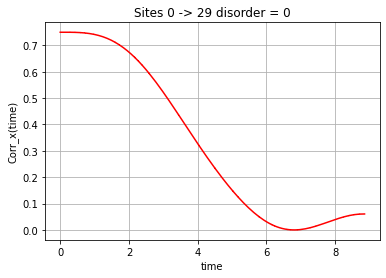

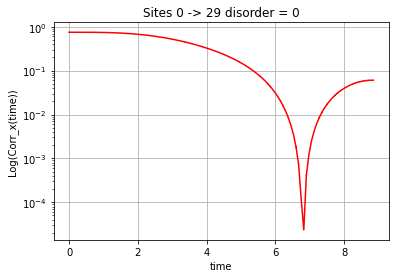

In [ ]:
!pip install pfapack
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from pfapack import pfaffian as pf
import numpy.matlib
import plotly.graph_objects as go
import linecache
from google.colab import drive
# drive.flush_and_unmount()
drive.mount("/content/drive")

seed = 53
np.random.seed(seed)

# Barouch's solution
 
def hamiltonian(fields, interactions):
    '''
    calculates hamiltonian from field and bonds values
    as in Barouch(I), formula 2.4
    '''
    mid = np.zeros((num_of_spins, num_of_spins))
    up = np.zeros((num_of_spins, num_of_spins))
    dn = np.zeros((num_of_spins, num_of_spins))
    for position in range(num_of_spins):
        mid[position][position] = float(fields[position]) / 2
    for position in range(num_of_spins - 1):
        up[position][position + 1] = float(interactions[position]) / 4
        dn[position + 1][position] = float(interactions[position]) / 4
    a = (mid - up - dn)
    b = -(up - dn)
    return np.block([[- a, - b], [b, a]])
 
def gamma(old_occ_nums, old2new):
    '''
    calculates new occupation numbers (icluding cross-terms) at time = 0 
    from initial (old) occupation numbers
    '''
    return np.matmul(old2new, np.matmul(old_occ_nums, np.transpose(old2new)))

def gamma_t(energies, time):
    '''
    calculates new matrix_ij = <gamma_i gamma_j> at a given time
    energies = (e1, ..., en, ) - all positive eigenvals of ham (energy/2)
    old2new - transfer matrix: (g1 ... g1^T ...)_old = old2new * (g1 ... g1^T ...)_new
    evolution is driven by multiplying by exponent of the sum of corresponding energies
    '''
    return gamma_precalc * np.array([[np.exp(-2j*(energies[fst_g_ind] + energies[snd_g_ind]) * time) for fst_g_ind in range(2 * num_of_spins)] for snd_g_ind in range(2 * num_of_spins)])
 
def c_ij_t(newU, gamma_time):
    '''
    calculates c-correlators from gamma(new)-correlators
    '''
    return np.matmul(newU, np.matmul(gamma_time, np.transpose(newU)))

def magn_z(c_ij_t_precalc, site):
    return (1 - 2 * c_ij_t_precalc[site + n, site])

def sub_mat(c_ij_t_precalc, p, q, sub_mat_type):
    '''
    constructs submatrices S, G, Q from c-correlators
    p, q are sites for which correlator is calculated
    '''
    if sub_mat_type == 'S':
        signs = np.array([1,-1,-1,1])
    elif sub_mat_type == 'G':
        signs = np.array([1,1,-1,-1])
    elif sub_mat_type == 'Q':
        signs = np.array([1,1,1,1])
    def elem(l, m):
        if (sub_mat_type == 'S' or sub_mat_type == 'Q') and l == m:
            return 0
        cln_cmn = c_ij_t_precalc[l + num_of_spins, m + num_of_spins]
        cl_cm = c_ij_t_precalc[l, m]
        cln_cm = c_ij_t_precalc[l + num_of_spins, m]
        cl_cmn = c_ij_t_precalc[l, m + num_of_spins]
        return np.matmul(signs, np.array([cln_cmn, cln_cm, cl_cmn, cl_cm]))
    submt = np.array([[elem(a, b) for b in range(p, q)] for a in range(p, q)])
    return submt
    
def rho_x(S_whole, Q_whole, G_whole, site):
    '''
    assembles matrix for x correlations from submatrices S, G, Q and returns its pfaffian
    '''
    S = S_whole[0:site, 0:site]
    Q = Q_whole[1:(site + 1), 1:(site + 1)]
    G = G_whole[0:site, 1:(site + 1)]
    R_x = np.block([[S, G], [-np.transpose(G), Q]])
    return ((-1)**(site * (site - 1) / 2)) * pf.pfaffian((R_x - np.transpose(R_x)) / 2)

def eig_energies_states(ham):
    '''
    returns e - eigenenrgies of ham: e1, e2, ... -e1, -e2, ... and
    u - transfer: gamma = u * c
    '''
    e, u = np.linalg.eigh(ham)
    idx = np.argsort(e)[::-1]
    e = e[idx]
    e = np.concatenate((e[:num_of_spins], e[-1:num_of_spins - 1:-1]))
    u = u[:,idx]
    u = np.concatenate((u[:,:num_of_spins], u[:,-1:num_of_spins-1:-1]), axis=1)
    u1 = u[:num_of_spins, :num_of_spins]
    u2 = u[num_of_spins:, :num_of_spins]
    u = np.block([[u1, u2], [u2, u1]])
    return (e, u)

def rho_z(S_whole, Q_whole, G_whole, site):
    '''
    assembles matrix for x correlations from submatrices S, G, Q and returns its pfaffian
    '''
    def submat_z(submat_whole):
        return np.array([[submat_whole[0, 0], submat_whole[0, site]],[submat_whole[site, 0], submat_whole[site, site]]])
    S_z = submat_z(S_whole)
    Q_z = submat_z(Q_whole)
    G_z = submat_z(G_whole)
    R_z = np.block([[S_z, G_z], [-np.transpose(G_z), Q_z]])
    return -np.real_if_close(pf.pfaffian((R_z - np.transpose(R_z)) / 2))

def oc_num_0(temperature, e):
    '''
    from temperature and initial energies calculates
    initial (old) occupation numbers (gamma^dagger gamma)
    '''
    if temperature == 0:
        nums = np.zeros(num_of_spins)
    else:
        nums = (1 / (1 + np.exp(2 * e[:num_of_spins] / temperature)))
    return np.block([[np.zeros((num_of_spins, num_of_spins)), np.diag(1 - nums)], [np.diag(nums), np.zeros((num_of_spins, num_of_spins))]])

'''
initialization
'''
plots_folder = f"/content/drive/MyDrive/RQC/continuous_ham_plots_fields_{fields_init_av}_to_{fields_fin_av}"
pre_quench_states = "/content/drive/MyDrive/RQC/continuous_ham_states.txt"
correl_data = '/content/drive/My Drive/RQC/correl_data.txt'
ham_params = '/content/drive/My Drive/RQC/ham_params.txt'

!mkdir $plots_folder
num_of_quenches = 0

def params(num_of_quench):
    '''
    returns a dictionary with line numbers of different parameters
    dictionary keys: fields, interactions, temperature, time_span, time_resol
    '''
    return {"num_of_spins":(8 * num_of_quench + 1), "fields":(8 * num_of_quench + 8), "interactions":(8 * num_of_quench + 6), "temperature":(8 * num_of_quench + 2), "time_span":(8 * num_of_quench + 3), "time_resol":(8 * num_of_quench + 4)}
        

def time_fermi(fields, interactions):
    v_max = 2 * np.average(abs(interactions)) * min(np.average(abs(fields)), 1)
    return num_of_spins / (2 * v_max)

num_of_quench = 0
# TODO: make correlations np.arrays from the beginning 
correlations_x = []
correlations_z = []
while True:
    parameters = params(num_of_quench)
    num_of_spins = int(linecache.getline(ham_params, parameters["num_of_spins"]))
    temperature = float(linecache.getline(ham_params, parameters["temperature"]))
    time_span = float(linecache.getline(ham_params, parameters["time_span"]))
    time_resol = int(linecache.getline(ham_params, parameters["time_resol"]))
    if num_of_quench == 0:
        interactions_2 = np.fromstring(linecache.getline(ham_params, parameters["interactions"]), sep=" ")
        fields_2 = np.fromstring(linecache.getline(ham_params, parameters["fields"]), sep=" ")
        interactions_1 = interactions_2
        fields_1 = fields_2
    else:
        interactions_1 = interactions_2
        fields_1 = fields_2
        interactions_2 = np.fromstring(linecache.getline(ham_params, parameters["interactions"]), sep=" ")
        fields_2 = np.fromstring(linecache.getline(ham_params, parameters["fields"]), sep=" ")
    '''
    Note that time_fermi (and consequently time) may vary from experiment to experiment because of random fields
    '''
    time = numpy.linspace(0.0, time_span * time_fermi(fields_2, interactions_2), num=time_resol)
    if num_of_quench:
        global_time = np.concatenate((global_time, time + global_time[-1]))
    else:
        global_time = time
    '''
    precalculate values for reuse
    gamma_new = old2new * gamma_old
    '''
    energies_old, c2g_old = eig_energies_states(hamiltonian(fields_1, interactions_1))
    energies_new, c2g_new = eig_energies_states(hamiltonian(fields_2, interactions_2))
    gamma_old = gamma_time if num_of_quench else oc_num_0(temperature, energies_old)
    old2new_precalc = np.matmul(np.transpose(c2g_new), c2g_old)
    gamma_precalc = gamma(gamma_old, old2new_precalc)

    '''
    correlators construction
    '''
    for time_moment in time:
        corr_fix_time_x = []
        corr_fix_time_z = []
        gamma_time = gamma_t(energies_new, time_moment)
        c_ij_t_precalc = c_ij_t(c2g_new, gamma_time)
        S_precalc = sub_mat(c_ij_t_precalc, 0, num_of_spins, 'S')
        Q_precalc = sub_mat(c_ij_t_precalc, 0, num_of_spins, 'Q')
        G_precalc = sub_mat(c_ij_t_precalc, 0, num_of_spins, 'G')
        for site in range(num_of_spins):
            if site == 0:
                corr_fix_time_x.append(1)
                corr_fix_time_z.append(1)
            else:
                corr_fix_time_x.append(rho_x(S_precalc, Q_precalc, G_precalc, site))
                corr_fix_time_z.append(rho_z(S_precalc, Q_precalc, G_precalc, site))
        correlations_x.append(corr_fix_time_x)
        correlations_z.append(corr_fix_time_z)
    # with open(pre_quench_states, "w") as f:
    #     f.write(str(gamma_time))
    # with open(correl_data, "a") as f:
    #     f.write(f"temperature = {temperature} \n")
    #     np.savetxt(f,fields_1, delimiter=' ', newline='\n', header='fields_1 = ')
    #     np.savetxt(f,interactions_1, delimiter=' ', newline='\n', header='interactions_1 = ')
    #     np.savetxt(f,fields_2, delimiter=' ', newline='\n', header='fields_2 = ')
    #     np.savetxt(f,interactions_2, delimiter=' ', newline='\n', header='interactions_2 = ')
    #     np.savetxt(f,correlations_x, delimiter=' ', newline='\n', header='correlations_x = ')
    #     np.savetxt(f,correlations_z, delimiter=' ', newline='\n', header='correlations_z = ')
    num_of_quench += 1
    if not linecache.getline(ham_params, parameters["fields"] + 1):
        break

correlations_x = np.real(np.transpose(np.array(correlations_x)))
correlations_z = np.real(np.transpose(np.array(correlations_z)))
plt.plot(global_time, np.real_if_close(correlations_x[num_of_spins-1,:]), 'r-')
plt.xlabel("time")
plt.ylabel("Corr_x(time)")
plt.grid()
plt.title(f"Sites 0 -> {num_of_spins-1} disorder = {disorder}")
file_name = plots_folder + f"/site_number={num_of_spins-1}_disorder_{disorder}_Corr_x_time.pdf"
!touch $file_name
plt.savefig(file_name)
plt.show()

plt.semilogy(global_time, np.real_if_close(correlations_x[num_of_spins-1,:]), 'r-')
plt.xlabel("time")
plt.ylabel("Log(Corr_x(time))")
plt.grid()
plt.title(f"Sites 0 -> {num_of_spins-1} disorder = {disorder}")
file_name = plots_folder + f"/site_number={num_of_spins-1}_disorder_{disorder}_Corr_x_time_semilog.pdf"
!touch $file_name
plt.savefig(file_name)
plt.show()
# for t in range(len(time)):
#     plt.plot(dist[1:], np.real_if_close(correlations_z[:,t], tol=1000)[1:], 'r-', label="fast")
# plt.xlabel("distance")
# plt.ylabel("Corr_z(dist)")
# plt.grid()
# plt.show()

# dist = np.arange(num_of_spins)
# for t in range(len(time)):
#     plt.plot(dist[1:], np.real_if_close(correlations_x[:,t], tol=1000)[1:], 'r-', label="fast")
# plt.xlabel("distance")
# plt.ylabel("Corr_x(dist)")
# plt.grid()
# plt.show()

# fig = go.Figure(data=[
#     go.Surface(z=correlations_x),
#     go.Surface(z=correlations_z, showscale=False, opacity=0.9),
#     # go.Surface(z=z3, showscale=False, opacity=0.9)

# ])

# fig.show()